In [1]:
import pymongo
cli = pymongo.MongoClient()
db = cli.test
coll = db.stress
coll.drop()

In [2]:
import time
from functools import wraps

def timed(label):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            n = kwargs.get('n')
            bs = kwargs.get('bs', 1)
            begin = time.time()
            try:
                return func(*args, **kwargs)
            finally:
                elapsed = time.time() - begin
                if n:
                    if bs:
                        n *= bs
                    print('{} {} / s'.format(
                        n / elapsed,
                        label))
                else:
                    print('{}: {}s elapsed'.format(
                        label, elapsed))
        return wrapper
    return decorator

In [3]:
@timed('inserts')
def insert_test(coll, n=1000, bs=1000):
    for ix_n in range(n):
        block = [
            {'ix_n': ix_n, 'ix_b': ix_b}
            for ix_b in range(bs)]
        coll.insert_many(block)
        if ix_n % 40 == 0:
            print()
        print('.', end='', flush=True)
    print()

In [4]:
import random
@timed('queries')
def query_test(coll, max_ix_b, max_ix_n, n=100, bs=10):
    for ix_n in range(n):
        rv_n = random.randint(0, max_ix_n + 1)
        rv_b = random.randint(0, max_ix_b + 1)
        res = coll.find({
            'ix_n': rv_n,
            'ix_b': {'$gt': rv_b}
        })
        list(res)


In [5]:
@timed('updates')
def update_test(coll, max_ix_b, max_ix_n, n=10000):
    for ix_n in range(n):
        rv_n = random.randint(0, max_ix_n + 1)
        rv_b = random.randint(0, max_ix_b + 1)
        coll.update_one(
            {'ix_n': rv_n, 'ix_b': rv_b},
            {'$inc': {'x': 1}})

In [6]:
insert_test(coll, n=500, bs=1000)


........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
....................
55123.794021123635 inserts / s


In [7]:
max_ix_b = 999
max_ix_n = 499

In [8]:
coll.drop_indexes()

In [9]:
db.set_profiling_level(1)

In [10]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.8404010663905215 queries / s


In [11]:
doc = db.system.profile.find_one(sort=[('ts', -1)])

In [12]:
doc

{'allUsers': [],
 'client': '172.17.0.1',
 'cursorExhausted': True,
 'cursorid': 418239177067.0,
 'docsExamined': 436759,
 'execStats': {'advanced': 860,
  'direction': 'forward',
  'docsExamined': 500000,
  'executionTimeMillisEstimate': 159,
  'filter': {'$and': [{'ix_n': {'$eq': 63}}, {'ix_b': {'$gt': 139}}]},
  'invalidates': 0,
  'isEOF': 1,
  'nReturned': 860,
  'needTime': 499141,
  'needYield': 0,
  'restoreState': 3909,
  'saveState': 3909,
  'stage': 'COLLSCAN',
  'works': 500002},
 'keysExamined': 0,
 'locks': {'Collection': {'acquireCount': {'r': 3415}},
  'Database': {'acquireCount': {'r': 3415}},
  'Global': {'acquireCount': {'r': 6830}}},
 'millis': 138,
 'nreturned': 759,
 'ns': 'test.stress',
 'numYield': 3414,
 'op': 'getmore',
 'originatingCommand': {'filter': {'ix_b': {'$gt': 139}, 'ix_n': 63},
  'find': 'stress'},
 'planSummary': 'COLLSCAN',
 'protocol': 'op_query',
 'query': {'collection': 'stress', 'getMore': 418239177067},
 'responseLength': 35661,
 'ts': dateti

In [13]:
for doc in db.system.profile.find({'op': {'$ne': 'command'}}).sort([('ts', -1)]).limit(10):
    print('{millis} {query}'.format(**doc))

138 {'getMore': 418239177067, 'collection': 'stress'}
132 {'getMore': 416943943993, 'collection': 'stress'}
145 {'getMore': 417610898778, 'collection': 'stress'}
136 {'find': 'stress', 'filter': {'ix_n': 386, 'ix_b': {'$gt': 345}}}
127 {'getMore': 417155671486, 'collection': 'stress'}
167 {'find': 'stress', 'filter': {'ix_n': 50, 'ix_b': {'$gt': 980}}}
115 {'find': 'stress', 'filter': {'ix_n': 369, 'ix_b': {'$gt': 568}}}
120 {'getMore': 418265215831, 'collection': 'stress'}
170 {'find': 'stress', 'filter': {'ix_n': 421, 'ix_b': {'$gt': 958}}}
154 {'find': 'stress', 'filter': {'ix_n': 430, 'ix_b': {'$gt': 748}}}


In [14]:
db.set_profiling_level(2)

In [15]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.712664538760289 queries / s


In [16]:
for doc in db.system.profile.find({'op': {'$ne': 'command'}}).sort([('ts', -1)]).limit(10):
    print('{millis} {query}'.format(**doc))

103 {'getMore': 417337796129, 'collection': 'stress'}
66 {'find': 'stress', 'filter': {'ix_n': 196, 'ix_b': {'$gt': 748}}}
99 {'getMore': 419271561509, 'collection': 'stress'}
78 {'find': 'stress', 'filter': {'ix_n': 220, 'ix_b': {'$gt': 117}}}
182 {'find': 'stress', 'filter': {'ix_n': 439, 'ix_b': {'$gt': 968}}}
55 {'getMore': 420496421480, 'collection': 'stress'}
121 {'find': 'stress', 'filter': {'ix_n': 361, 'ix_b': {'$gt': 171}}}
18 {'getMore': 417403600789, 'collection': 'stress'}
150 {'find': 'stress', 'filter': {'ix_n': 464, 'ix_b': {'$gt': 638}}}
124 {'getMore': 418052314249, 'collection': 'stress'}


In [17]:
doc

{'allUsers': [],
 'client': '172.17.0.1',
 'cursorExhausted': True,
 'cursorid': 418052314249.0,
 'docsExamined': 367672,
 'execStats': {'advanced': 773,
  'direction': 'forward',
  'docsExamined': 500000,
  'executionTimeMillisEstimate': 155,
  'filter': {'$and': [{'ix_n': {'$eq': 132}}, {'ix_b': {'$gt': 226}}]},
  'invalidates': 0,
  'isEOF': 1,
  'nReturned': 773,
  'needTime': 499228,
  'needYield': 0,
  'restoreState': 3912,
  'saveState': 3912,
  'stage': 'COLLSCAN',
  'works': 500002},
 'keysExamined': 0,
 'locks': {'Collection': {'acquireCount': {'r': 2876}},
  'Database': {'acquireCount': {'r': 2876}},
  'Global': {'acquireCount': {'r': 5752}}},
 'millis': 124,
 'nreturned': 672,
 'ns': 'test.stress',
 'numYield': 2875,
 'op': 'getmore',
 'originatingCommand': {'filter': {'ix_b': {'$gt': 226}, 'ix_n': 132},
  'find': 'stress'},
 'planSummary': 'COLLSCAN',
 'protocol': 'op_query',
 'query': {'collection': 'stress', 'getMore': 418052314249},
 'responseLength': 31572,
 'ts': date

In [18]:
%matplotlib inline

In [19]:
import pandas as pd

In [20]:
from datetime import datetime
now = datetime.utcnow()

In [21]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.736319022788084 queries / s


In [22]:
df_pre_index = pd.DataFrame(list(db.system.profile.find({'ts': {'$gt': now}})))

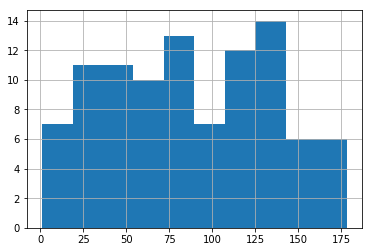

In [23]:
df_pre_index['millis'].hist()

In [24]:
coll.create_index([
    ('ix_n', 1)
])

'ix_n_1'

In [25]:
now = datetime.utcnow()

In [26]:
query_test(coll, max_ix_b, max_ix_n, n=50)

241.4104624338673 queries / s


In [27]:
df_post_index = pd.DataFrame(list(db.system.profile.find({'ts': {'$gt': now}})))

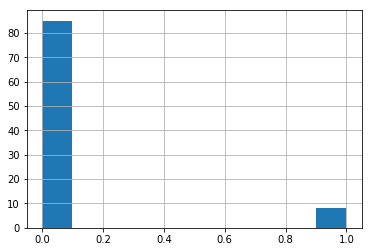

In [28]:
df_post_index['millis'].hist()

In [29]:
coll.drop_indexes()

In [30]:
db.set_profiling_level(0)

In [31]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.7725793890967205 queries / s


In [32]:
db.set_profiling_level(1, 200)

In [33]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.9663750144845515 queries / s


In [34]:
db.set_profiling_level(1, 10)

In [35]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.76451816628932 queries / s


In [36]:
db.set_profiling_level(2)

In [37]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.586251816265965 queries / s


In [38]:
db.set_profiling_level(1, 1000)

In [39]:
query_test(coll, max_ix_b, max_ix_n, n=50)

5.950570994927484 queries / s
